In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.ndimage as ndimage
import gc
from google.colab import drive
import cv2
from skimage import color, io, morphology, feature
import imageio
from skimage.util import img_as_ubyte

In [ ]:
drive.mount('/content/drive')
path = "/content/drive/My Drive/Brain_tumor"
path_training = path + "/Training"
path_testing = path + "/Testing"

list_train = os.listdir(path_training)
print(list_train)

Mounted at /content/drive
['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [ ]:
# paths to training dataset
train_glioma = [path_training + "/glioma_tumor" + '/' + img 
                          for img in os.listdir(path_training + '/' + "/glioma_tumor")]
train_meningioma = [path_training + "/meningioma_tumor" + '/' + img 
                          for img in os.listdir(path_training + '/' + "/meningioma_tumor")]
train_no_tumor = [path_training + "/no_tumor" + '/' + img 
                          for img in os.listdir(path_training + '/' + "/no_tumor")]
train_pituitary = [path_training + "/pituitary_tumor" + '/' + img 
                          for img in os.listdir(path_training + '/' + "/pituitary_tumor")]


# paths to testing dataset
test_glioma = [path_testing + "/glioma_tumor" + '/' + img 
                          for img in os.listdir(path_testing + '/' + "/glioma_tumor")]
test_meningioma = [path_testing + "/meningioma_tumor" + '/' + img 
                          for img in os.listdir(path_testing + '/' + "/meningioma_tumor")]
test_no_tumor = [path_testing + "/no_tumor" + '/' + img 
                          for img in os.listdir(path_testing + '/' + "/no_tumor")]
test_pituitary = [path_testing + "/pituitary_tumor" + '/' + img 
                          for img in os.listdir(path_testing + '/' + "/pituitary_tumor")]

In [ ]:
# paths to all dataset
train_path = [path_training + '/' + i + '/' + img 
                          for i in os.listdir(path_training) 
                          for img in os.listdir(path_training + '/' + i)
                          ]

test_path = [path_testing + '/' + i + '/' + img 
                          for i in os.listdir(path_testing) 
                          for img in os.listdir(path_testing + '/' + i)
                          ]

(512, 512, 3)


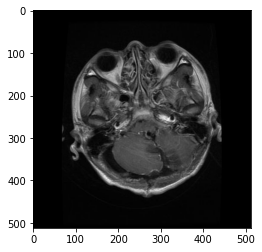

In [ ]:
# plot example image from glioma dataset
image = plt.imread(train_glioma[564])
plt.imshow(image)
print(image.shape)

(512, 512)


(-0.5, 511.5, 511.5, -0.5)

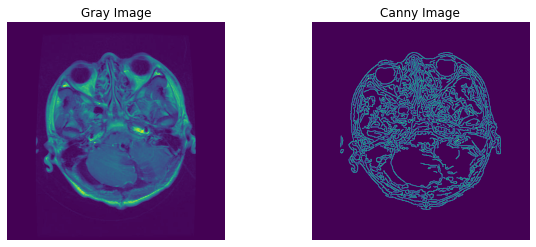

In [ ]:
# transfer to one channel
image_gray = color.rgb2gray(image)
print(image_gray.shape)
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(image_gray)
plt.title('Gray Image')
plt.axis('off')

# canny edge detection
image_canny = feature.canny(image_gray)
plt.subplot(122)
plt.imshow(image_canny)
plt.title('Canny Image')
plt.axis('off')

In [ ]:
def remove_noise(image):
    
    segmentation = morphology.dilation(image, np.ones((5, 5)))
    labels, label_nb = ndimage.label(segmentation)
    
    label_count = np.bincount(labels.ravel().astype(np.int))
    # The size of label_count is the number of classes/segmentations found
    
    # We don't use the first class since it's the background
    label_count[0] = 0
    
    # We create a mask with the class with more pixels
    # In this case should be the brain
    mask = labels == label_count.argmax()
    
    # Improve the brain mask
    mask = morphology.dilation(mask, np.ones((5, 5)))
    mask = ndimage.morphology.binary_fill_holes(mask)
    mask = morphology.dilation(mask, np.ones((3, 3)))
    
    masked_image = mask * image

    return mask, masked_image

(-0.5, 511.5, 511.5, -0.5)

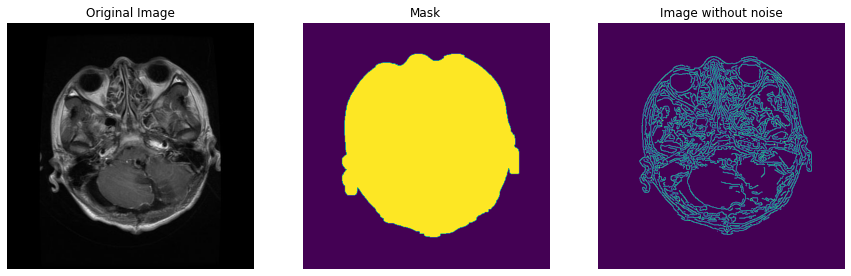

In [ ]:
mask, masked_image = remove_noise(image_canny)

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(132)
plt.imshow(mask)
plt.title('Mask')
plt.axis('off')

plt.subplot(133)
plt.imshow(masked_image)
plt.title('Image without noise')
plt.axis('off')

In [ ]:
def crop_square_image(canny_image, image):  

    # Create a mask with the background pixels
    mask = canny_image == 0.0
    # Find the brain area
    coords = np.array(np.nonzero(~mask))
    top_left = np.min(coords, axis=1)
    bottom_right = np.max(coords, axis=1)

    left_right = bottom_right[1] - top_left[1]
    top_bottom = bottom_right[0] - top_left[0]
    difference = abs(left_right - top_bottom)
    pad = int(difference/2)

    if left_right > top_bottom:
      if top_left[0]-pad < 0: 
          croped_image = image[top_left[0]:bottom_right[0]+difference,  
                              top_left[1]:bottom_right[1]]                 
      else: 
        if difference%2 == 0:
          croped_image = image[top_left[0]-pad:bottom_right[0]+pad,
                              top_left[1]:bottom_right[1]] 
        else:
          croped_image = image[top_left[0]-pad:bottom_right[0]+pad+1,
                              top_left[1]:bottom_right[1]] 
    else:
      if top_left[1]-pad < 0: 
          croped_image = image[top_left[0]:bottom_right[0],
                              top_left[1]:bottom_right[1]+difference]            
      else: 
        if difference%2 == 0:
          croped_image = image[top_left[0]:bottom_right[0],
                              top_left[1]-pad:bottom_right[1]+pad] 
        else:
          croped_image = image[top_left[0]:bottom_right[0],
                              top_left[1]-pad:bottom_right[1]+pad+1] 

    return croped_image

(-0.5, 368.5, 368.5, -0.5)

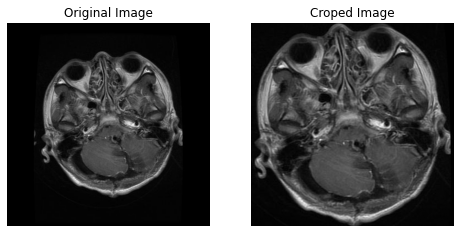

In [ ]:
croped_image = crop_square_image(masked_image, image_gray)
croped_image = color.gray2rgb(croped_image)

plt.figure(figsize=(8, 5))
plt.subplot(121)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(122)
plt.imshow(croped_image)
plt.title('Croped Image')
plt.axis('off')

In [ ]:
def square_crop(path, folder, brainFolder):
  for i in range(len(path)):
    image = plt.imread(path[i])   
    image_gray = color.rgb2gray(image)
    image_canny = feature.canny(image_gray)  
    mask, masked_image = remove_noise(image_canny)
    croped_image = crop_square_image(masked_image, image_gray)  
    image = color.gray2rgb(croped_image)
    image = img_as_ubyte(image)
    imageio.imwrite('/content/drive/My Drive/Brain_tumor/' + folder + '/'+ brainFolder + '/'+ str(i) +'.png' , image)

In [ ]:
# square crop images saving
square_crop(train_glioma, 'crop_square_train', 'glioma_tumor')
square_crop(train_meningioma, 'crop_square_train', 'meningioma_tumor')
square_crop(train_no_tumor, 'crop_square_train', 'no_tumor')
square_crop(train_pituitary, 'crop_square_train', 'pituitary_tumor')

In [ ]:
square_crop(test_glioma, 'crop_square_test', 'glioma_tumor')
square_crop(test_meningioma, 'crop_square_test', 'meningioma_tumor')
square_crop(test_no_tumor, 'crop_square_test', 'no_tumor')
square_crop(test_pituitary, 'crop_square_test', 'pituitary_tumor')

(-0.5, 368.5, 368.5, -0.5)

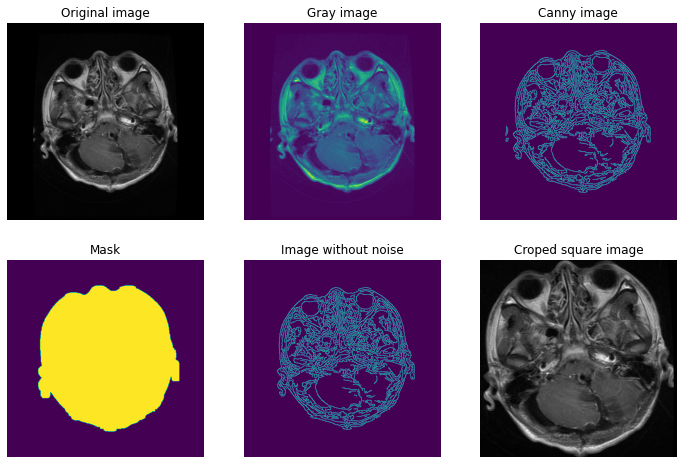

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(image)
plt.title('Original image')
plt.axis('off')

plt.subplot(232)
plt.imshow(image_gray)
plt.title('Gray image')
plt.axis('off')

plt.subplot(233)
plt.imshow(image_canny)
plt.title('Canny image')
plt.axis('off')

plt.subplot(234)
plt.imshow(mask)
plt.title('Mask')
plt.axis('off')

plt.subplot(235)
plt.imshow(masked_image)
plt.title('Image without noise')
plt.axis('off')

plt.subplot(236)
plt.imshow(croped_image)
plt.title('Croped square image')
plt.axis('off')